In [6]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import numpy as np
#Leer datos
df = pd.read_csv("/content/drive/MyDrive/NASA_Challenge_Data/aire_2000_2024_merged.csv",
                 sep=",",
                 usecols=["time","pm25_avg", "no2_avg", "o3_avg", "co_avg","T2M","U2M","V2M","PS"])
#df["Date Local"] = pd.to_datetime(df["Date Local"], dayfirst=True)
# Guardar fechas para uso posterior (gráficas, alinear predicciones)
fechas = df["time"]
data = df.drop(columns="time")
# Convertir a numpy para PyTorch
data = data.values.astype(np.float32)

scalers = {}

for i, col in enumerate(df.columns[1:]):
  scaler = MinMaxScaler()
  data[:, i] = scaler.fit_transform(df[[col]]).flatten()
  scalers[col] = scaler # Guardar scaler para desnormalizar luego


n=len(data)
n_train=int(n*0.7)
n_val=int(n*0.2)
n_prueba = n - n_train - n_val


data_train=data[:n_train]
data_val=data[n_train:n_train+n_val]
data_prueba=data[n_train+n_val:]

fechas_train = fechas[:n_train]
fechas_val = fechas[n_train:n_train+n_val]
fechas_test = fechas[n_train+n_val:]


#Crear secuencias
class SeaTempDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx+self.seq_len]
        label = self.data[idx+self.seq_len]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

#Defino cada dataset
seq_len=200
dataset_train = SeaTempDataset(data_train, seq_len=seq_len)
dataset_val= SeaTempDataset(data_val, seq_len=seq_len)
dataset_prueba= SeaTempDataset(data_prueba, seq_len=seq_len)

#Creo los dataloader de cada dataset
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader=DataLoader(dataset_val, batch_size=32, shuffle=False)
prueba_loader=DataLoader(dataset_prueba, batch_size=32, shuffle=False)

In [4]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 31.8 MB/s eta 0:00:00


### ***TUNEAR***

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Función objetivo para Optuna
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    seq_len = trial.suggest_int("seq_len", 100, 400, step=50)

    # Crear datasets con la nueva seq_len
    dataset_train_trial = SeaTempDataset(data_train, seq_len)
    dataset_val_trial = SeaTempDataset(data_val, seq_len)

    train_loader_trial = DataLoader(dataset_train_trial, batch_size=32, shuffle=True)
    val_loader_trial = DataLoader(dataset_val_trial, batch_size=32, shuffle=False)

    # Modelo
    net = Net(hidden_size=hidden_size, num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Entrenamiento rápido
    num_epochs = 50
    for epoch in range(num_epochs):
        net.train()
        for seqs, labels in train_loader_trial:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(seqs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validación
        net.eval()
        val_loss = 0
        with torch.no_grad():
            for seqs, labels in val_loader_trial:
                seqs, labels = seqs.to(device), labels.to(device)
                outputs = net(seqs)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader_trial)

        trial.report(val_loss, epoch)

        # ---- Poda temprana ----
        if trial.should_prune():
              raise optuna.TrialPruned()
    return val_loss

# Ejecutar Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)


[I 2025-10-05 05:25:34,568] A new study created in memory with name: no-name-db368abe-5eaa-4686-9deb-ef3ab0c50d8f
[I 2025-10-05 05:26:28,798] Trial 0 finished with value: 0.0032468219662809537 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.004851765239541554, 'seq_len': 400}. Best is trial 0 with value: 0.0032468219662809537.
[I 2025-10-05 05:27:26,367] Trial 1 finished with value: 0.0031941169779747727 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.00030610874731120123, 'seq_len': 250}. Best is trial 1 with value: 0.0031941169779747727.
[I 2025-10-05 05:28:02,320] Trial 2 finished with value: 0.004252130163109137 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00015128658052672688, 'seq_len': 400}. Best is trial 1 with value: 0.0031941169779747727.
[I 2025-10-05 05:30:22,500] Trial 3 finished with value: 0.0035169636178761722 and parameters: {'hidden_size': 128, 'num_layers': 4, 'lr': 0.007168150922270354, 'seq_len': 250}. Best is trial 1 with 

Mejores hiperparámetros encontrados:
{'hidden_size': 96, 'num_layers': 1, 'lr': 0.003334160704792259, 'seq_len': 200}


In [7]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class Net(nn.Module):
    def __init__(self,input_size=8,output_size=8,hidden_size=96,num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM=nn.LSTM(
        input_size=input_size, #debe ser el numero de variables
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True
        )
        self.fc=nn.Linear(hidden_size,output_size)

    def forward(self,x):
        h0=torch.zeros(self.LSTM.num_layers,x.size(0),self.hidden_size).to(x.device)
        c0=torch.zeros(self.LSTM.num_layers,x.size(0),self.hidden_size).to(x.device)
        out,_=self.LSTM(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(23)

In [8]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.0 MB/s eta 0:00:00


In [9]:


import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net=Net().to(device)
Criterion=nn.MSELoss()
optimizer=optim.Adam(net.parameters(),lr=0.003334160704792259)
mse=torchmetrics.MeanSquaredError().to(device)
num_epochs=100
losses = []
mejor_mse_val=float("inf")

for epoch in range(num_epochs):
    total_loss = 0
    mse_val=0
    net.train()
    for seqs,labels in train_loader:
        seqs=seqs.to(device)
        labels=labels.to(device)
        outputs=net(seqs)
        loss=Criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss=total_loss/len(train_loader)
    losses.append(total_loss)
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

    net.eval()
    mse.reset()
    with torch.no_grad():
        for seqs,labels in test_loader:
            seqs=seqs.to(device)
            labels=labels.to(device)
            #seqs=seqs.view(32,seq_len,4)##REVISAR
            outputs=net(seqs).squeeze()
            mse.update(outputs,labels)

    mse_val=mse.compute().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train avg Loss: {avg_loss:.4f}, Train loss: {total_loss: .4f}, Val MSE: {mse_val:.4f}")

    if mse_val < mejor_mse_val:
        mejor_mse_val = mse_val
        torch.save(net.state_dict(), "LSTM_PREDICTIONS.pth")
        print(" Modelo guardado con MSE:", mejor_mse_val)

cuda
Epoch 1/100, Train avg Loss: 0.0128, Train loss:  2.4851, Val MSE: 0.0054
 Modelo guardado con MSE: 0.005448716226965189
Epoch 2/100, Train avg Loss: 0.0059, Train loss:  1.1369, Val MSE: 0.0041
 Modelo guardado con MSE: 0.004094769712537527
Epoch 3/100, Train avg Loss: 0.0048, Train loss:  0.9345, Val MSE: 0.0042
Epoch 4/100, Train avg Loss: 0.0044, Train loss:  0.8562, Val MSE: 0.0035
 Modelo guardado con MSE: 0.003539514495059848
Epoch 5/100, Train avg Loss: 0.0042, Train loss:  0.8127, Val MSE: 0.0038
Epoch 6/100, Train avg Loss: 0.0041, Train loss:  0.8009, Val MSE: 0.0031
 Modelo guardado con MSE: 0.0030852637719362974
Epoch 7/100, Train avg Loss: 0.0040, Train loss:  0.7786, Val MSE: 0.0031
Epoch 8/100, Train avg Loss: 0.0039, Train loss:  0.7635, Val MSE: 0.0031
Epoch 9/100, Train avg Loss: 0.0039, Train loss:  0.7619, Val MSE: 0.0030
 Modelo guardado con MSE: 0.0030044838786125183
Epoch 10/100, Train avg Loss: 0.0039, Train loss:  0.7596, Val MSE: 0.0031
Epoch 11/100, Tra

In [11]:
import torchmetrics
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=Net().to(device)
net.load_state_dict(torch.load("LSTM_PREDICTIONS.pth"))

mse_test = torchmetrics.MeanSquaredError().to(device)
net.eval()

all_preds = []
all_labels = []

mse_test.reset()

with torch.no_grad():
    for seqs, labels in prueba_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)
        outputs = net(seqs)
        mse_test.update(outputs, labels)
        all_preds.append(outputs)
        all_labels.append(labels)


prueba_mse = mse_test.compute()
print(f" Error MSE de prueba: {prueba_mse:.4f}")


 Error MSE de prueba: 0.0025


In [12]:
import matplotlib.pyplot as plt

all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy() # Definir el punto de inicio de las fechas para el conjunto de prueba
start_index = n_train + n_val + seq_len
fechas_prueba = fechas[-len(all_labels):] # Desnormalizar columna por columna

all_preds_real = np.zeros_like(all_preds)
all_labels_real = np.zeros_like(all_labels)

for i, col in enumerate(df.columns[1:]): # iterar por cada gas
  all_preds_real[:, i] = scalers[col].inverse_transform(all_preds[:, i].reshape(-1,1)).flatten()
  all_labels_real[:, i] = scalers[col].inverse_transform(all_labels[:, i].reshape(-1,1)).flatten()

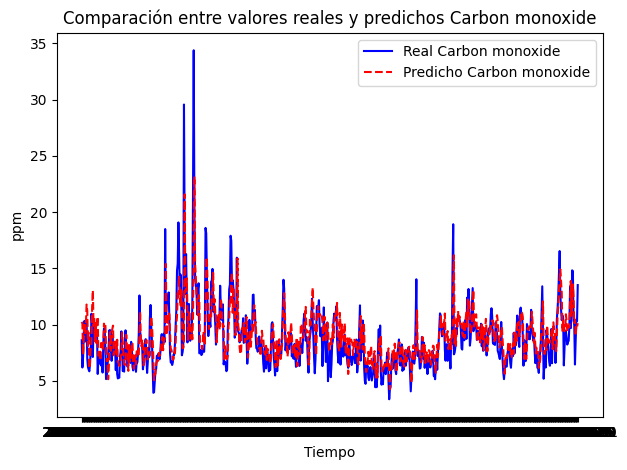

In [13]:


plt.plot(figsize=(12,6))
plt.plot(fechas_prueba,all_labels_real[:, 0], label="Real Carbon monoxide", color="blue")
plt.plot(fechas_prueba,all_preds_real[:, 0], label="Predicho Carbon monoxide", color="red", linestyle="--")
plt.title("Comparación entre valores reales y predichos Carbon monoxide")
plt.xlabel("Tiempo")
plt.ylabel("ppm")
plt.legend()
plt.tight_layout()
plt.show()

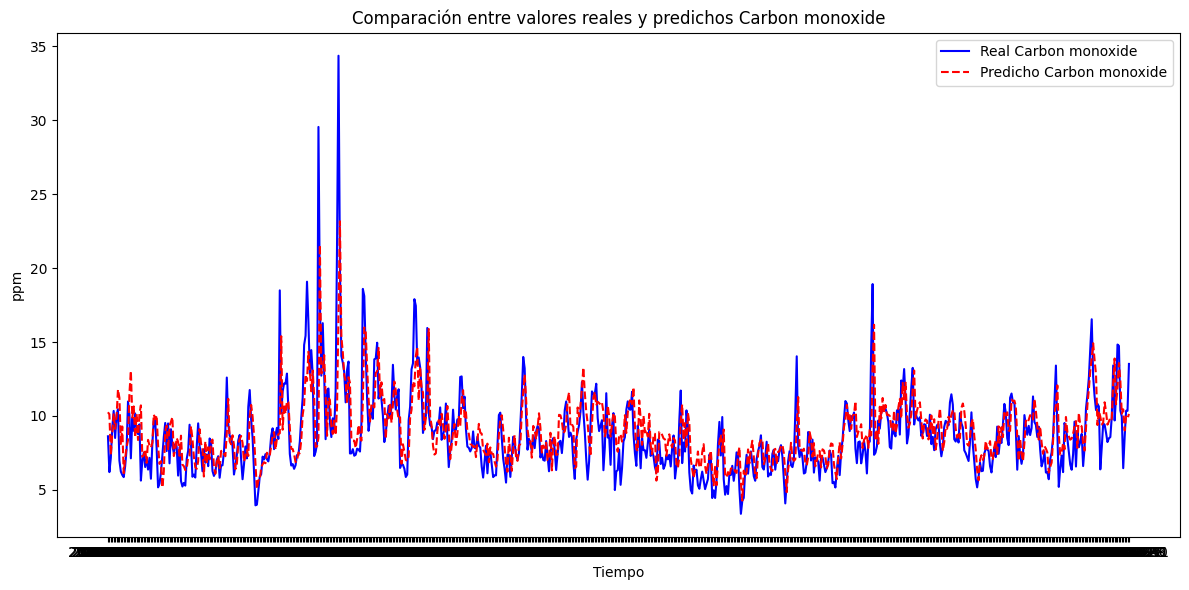

In [14]:
# Crear figura y ejes correctamente
fig, ax = plt.subplots(figsize=(12,6))  # tamaño de la figura
fig.patch.set_facecolor("white")       # fondo de la figura
ax.set_facecolor("white")               # fondo del eje

# Graficar
ax.plot(fechas_prueba, all_labels_real[:, 0], label="Real Carbon monoxide", color="blue")
ax.plot(fechas_prueba, all_preds_real[:, 0], label="Predicho Carbon monoxide", color="red", linestyle="--")

# Personalizar
ax.set_title("Comparación entre valores reales y predichos Carbon monoxide")
ax.set_xlabel("Tiempo")
ax.set_ylabel("ppm")
ax.legend()


plt.tight_layout()
plt.show()

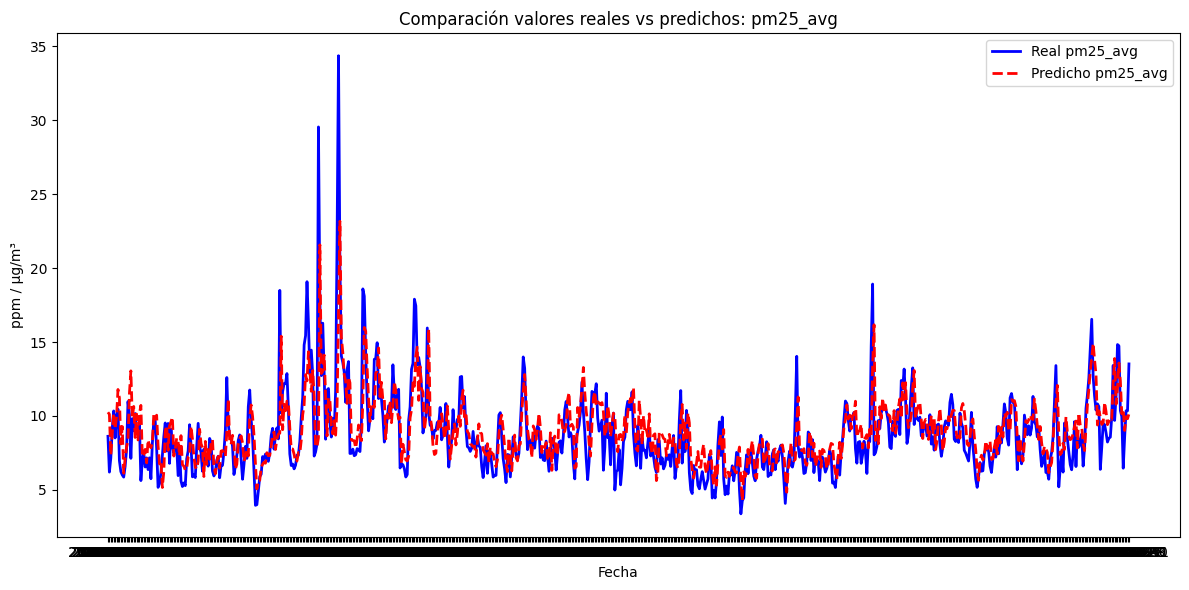

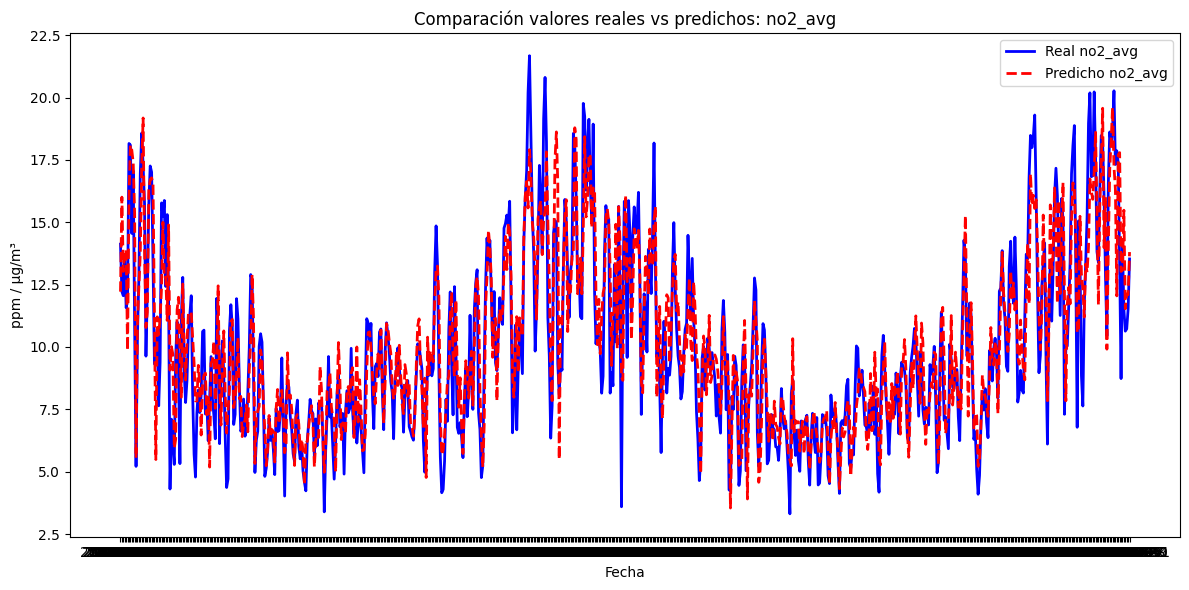

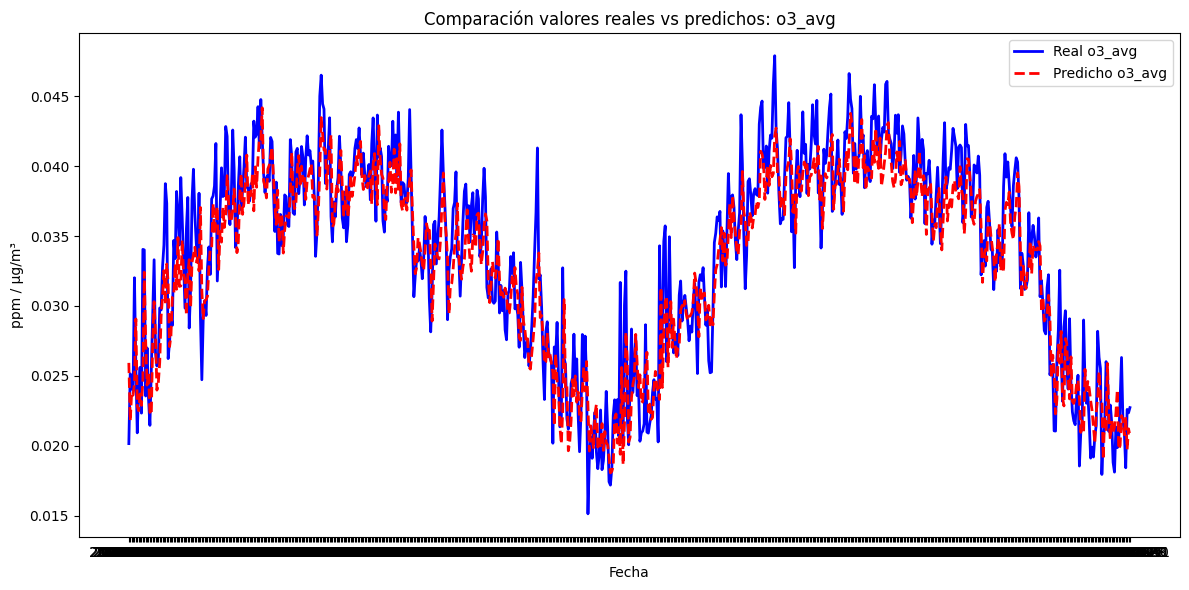

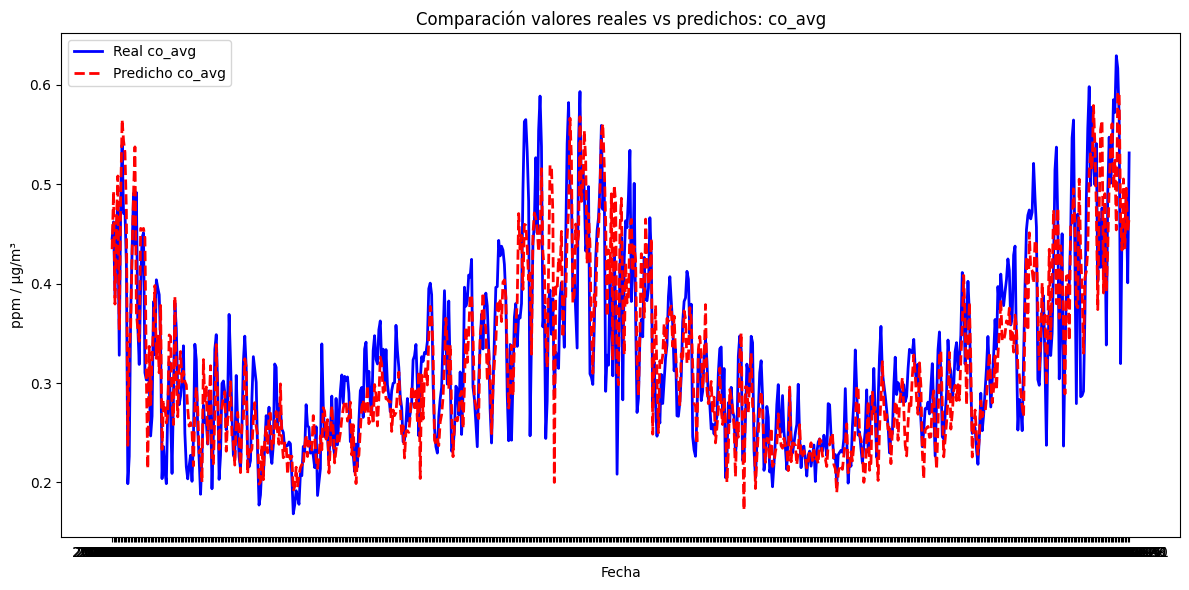

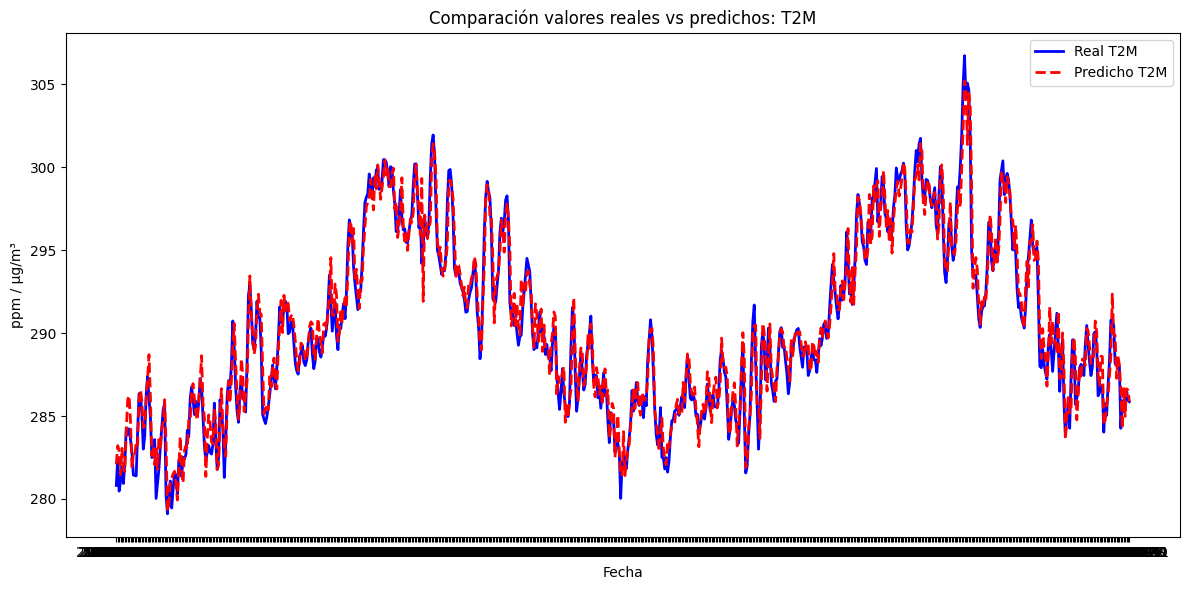

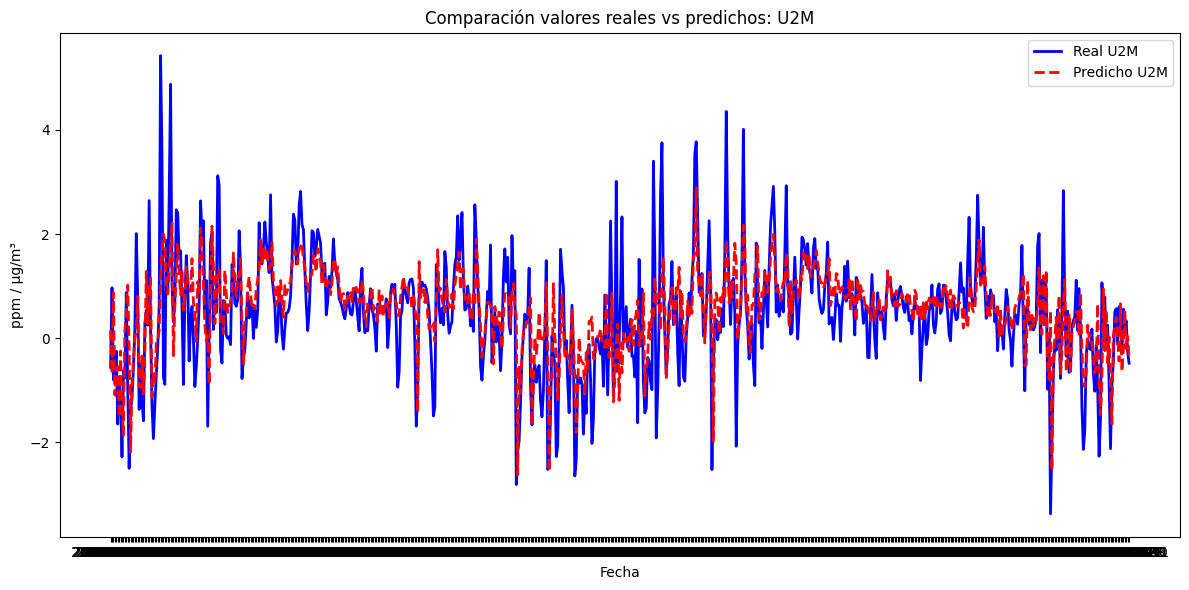

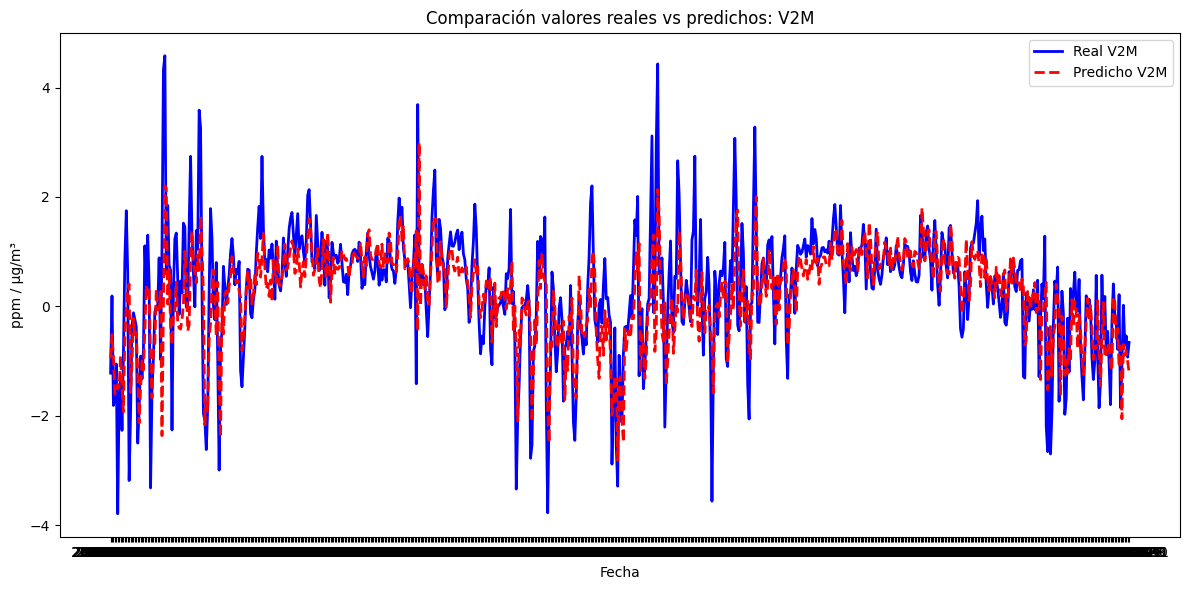

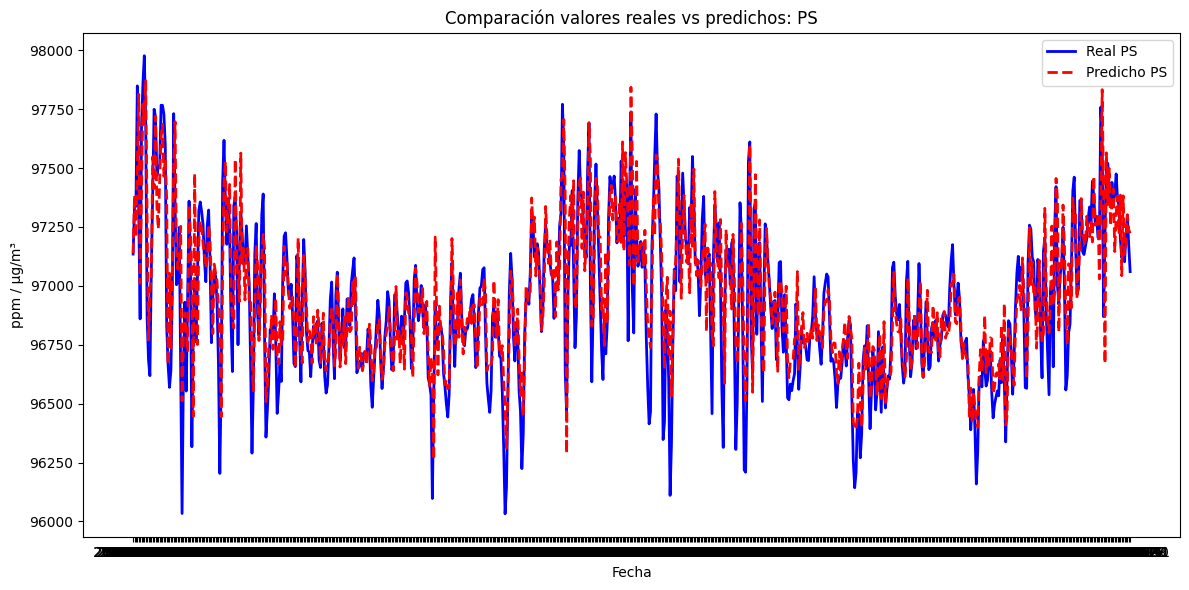

In [15]:
import matplotlib.pyplot as plt

# Nombres de los gases
gases = ["pm25_avg", "no2_avg", "o3_avg", "co_avg","T2M","U2M","V2M","PS"]

# Colores
color_real = "#1f77b4"   # azul para real
color_pred = "#d62728"   # rojo para predicho

# Crear 4 plots por separado
for i, gas in enumerate(gases):
    fig, ax = plt.subplots(figsize=(12,6))
    fig.patch.set_facecolor("white")  # fondo figura
    ax.set_facecolor("white")          # fondo eje

    # Graficar real y predicho
    ax.plot(fechas_prueba, all_labels_real[:, i], label=f"Real {gas}", color="blue", linewidth=2)
    ax.plot(fechas_prueba, all_preds_real[:, i], label=f"Predicho {gas}", color="red", linestyle="--", linewidth=2)

    # Personalizar
    ax.set_title(f"Comparación valores reales vs predichos: {gas}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("ppm / µg/m³")
    ax.legend()


    plt.tight_layout()
    plt.show()


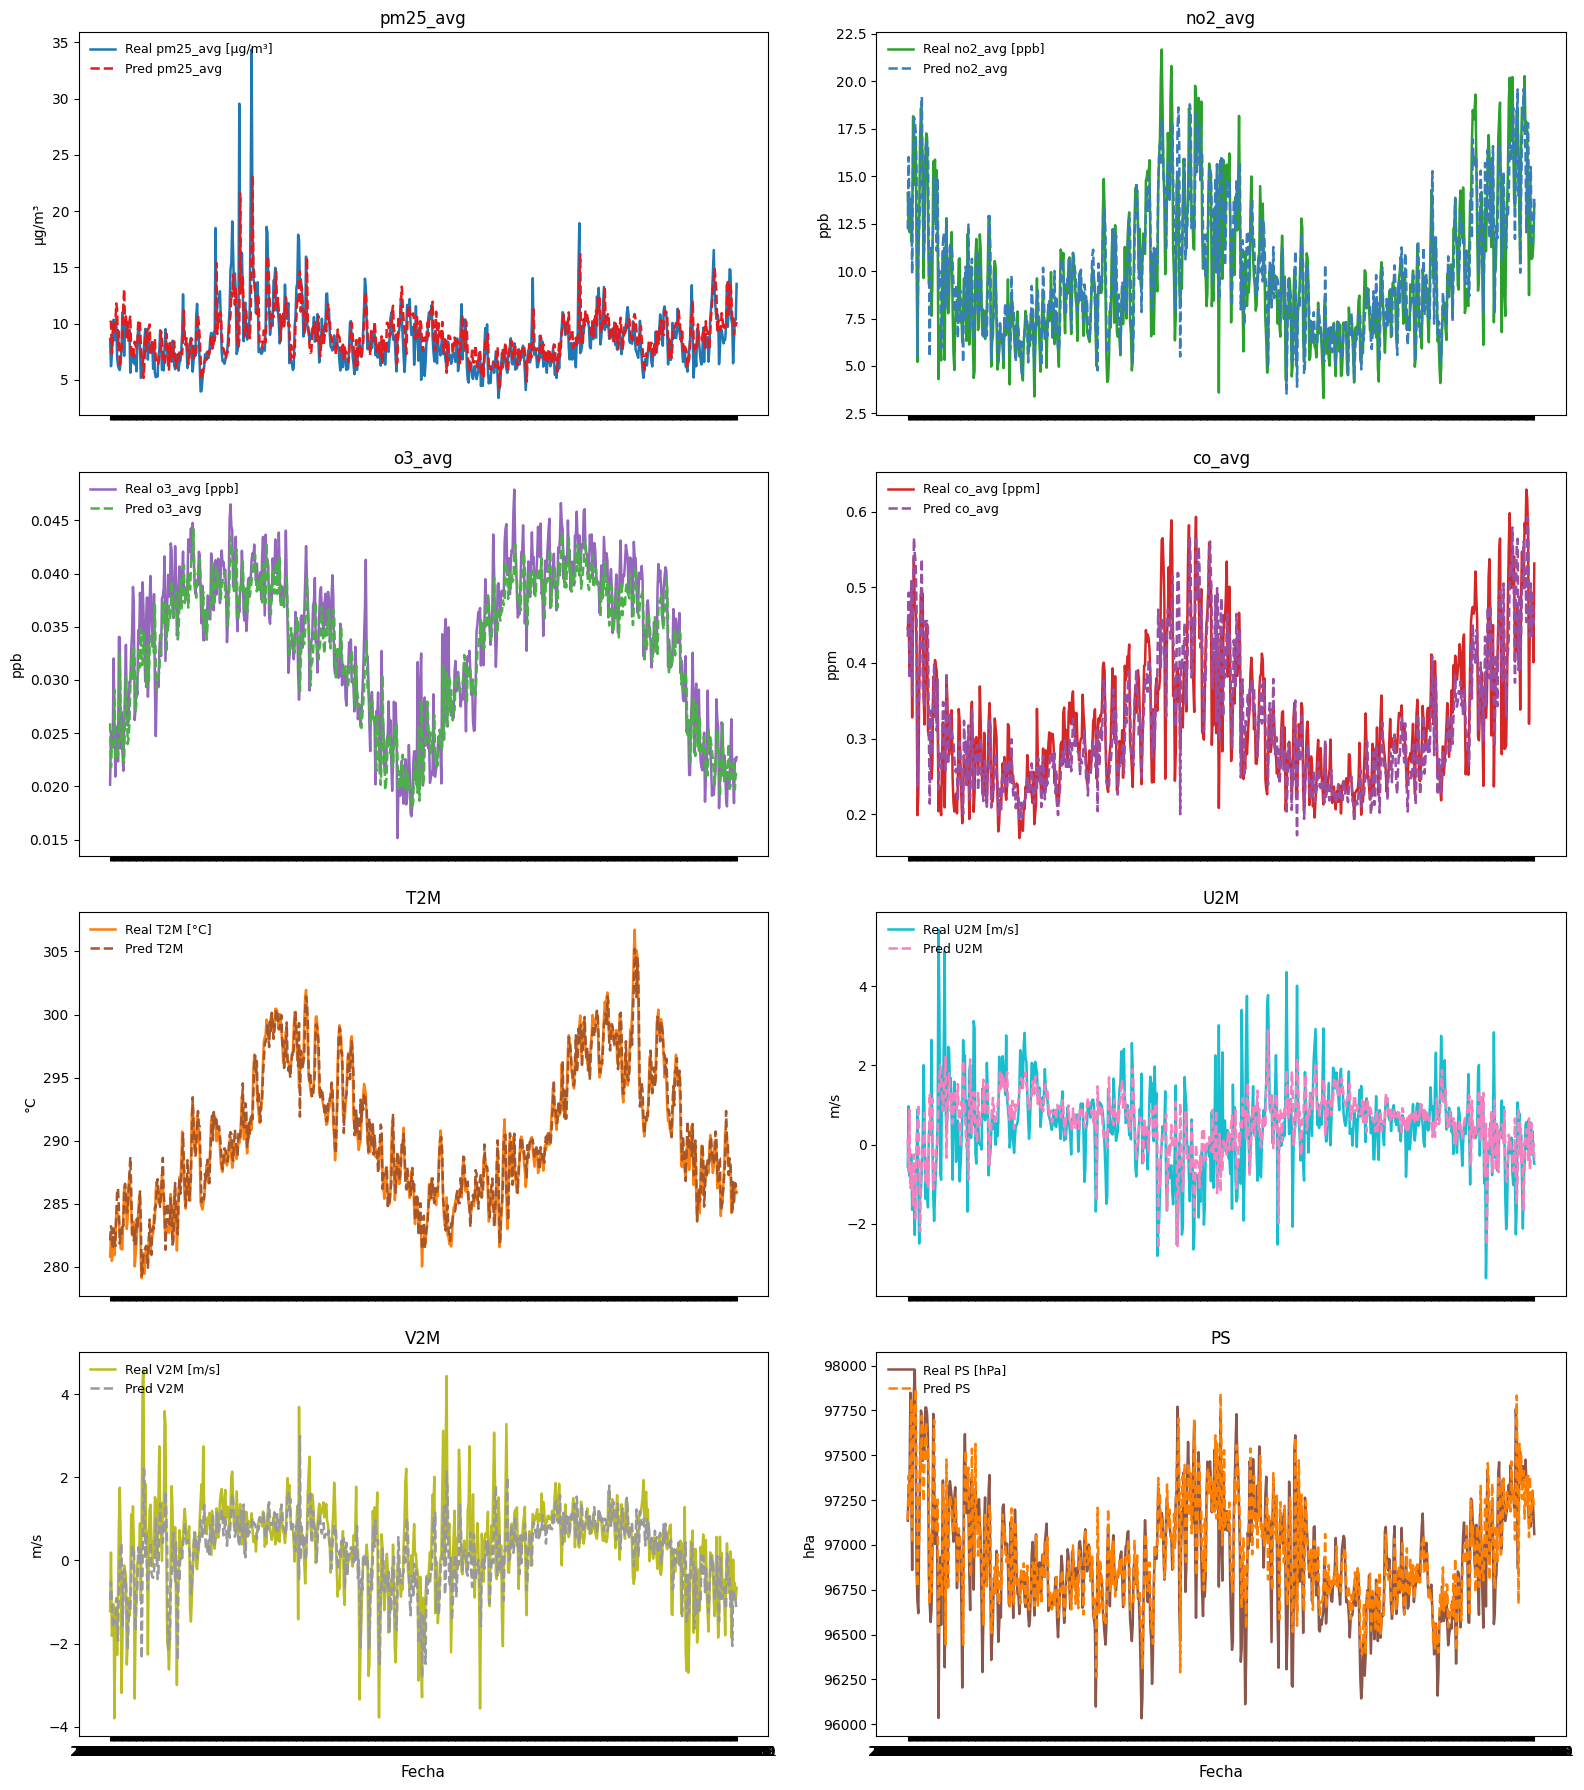

In [18]:
import matplotlib.pyplot as plt

# Nombres de los gases y colores
PARAMS = ["pm25_avg", "no2_avg", "o3_avg", "co_avg","T2M","U2M","V2M","PS"]
# Paleta (REAL) que ya tienes:
UNIDADES = {
    "pm25_avg": "µg/m³",  # PM2.5
    "no2_avg":  "ppb",    # NO2 (usa µg/m³ si corresponde)
    "o3_avg":   "ppb",    # O3
    "co_avg":   "ppm",    # CO
    "T2M":      "°C",     # Temperatura a 2 m
    "U2M":      "m/s",    # Viento zonal a 2 m
    "V2M":      "m/s",    # Viento meridional a 2 m
    "PS":       "hPa",    # Presión superficial (si está en Pa, divide entre 100)
}
COLORS = {
    "pm25_avg": "#1f77b4",  # azul
    "no2_avg":  "#2ca02c",  # verde
    "o3_avg":   "#9467bd",  # púrpura
    "co_avg":   "#d62728",  # rojo
    "T2M":      "#ff7f0e",  # naranja
    "U2M":      "#17becf",  # cian
    "V2M":      "#bcbd22",  # oliva
    "PS":       "#8c564b",  # marrón
}

# Nueva paleta (PRED) con alto contraste variable-a-variable:
PRED_COLORS = {
    "pm25_avg": "#e41a1c",  # rojo vivo (contrasta con azul real)
    "no2_avg":  "#377eb8",  # azul (contrasta con verde real)
    "o3_avg":   "#4daf4a",  # verde (contrasta con púrpura real)
    "co_avg":   "#984ea3",  # púrpura (contrasta con rojo real)
    "T2M":      "#a65628",  # café/rust (contrasta con naranja real)
    "U2M":      "#f781bf",  # rosa (contrasta con cian real)
    "V2M":      "#999999",  # gris neutro (contrasta con oliva real)
    "PS":       "#ff7f00",  # naranja vivo (contrasta con marrón real)
}

LINESTYLE = {"real": "solid", "pred": "dashed"}

ig, axes = plt.subplots(4, 2, figsize=(16, 18), sharex=True)
axes = axes.ravel()
fig.patch.set_facecolor("white")

for i, param in enumerate(PARAMS):
    ax = axes[i]
    ax.set_facecolor("white")

    # Serie real
    ax.plot(
        fechas_prueba,
        all_labels_real[:, i],
        label=f"Real {param} [{UNIDADES.get(param, '')}]",
        color=COLORS[param],
        linestyle=LINESTYLE["real"],
        linewidth=1.8
    )

    # Serie predicha
    ax.plot(
        fechas_prueba,
        all_preds_real[:, i],
        label=f"Pred {param}",
        color=PRED_COLORS[param],
        linestyle=LINESTYLE["pred"],
        linewidth=1.8
    )

    ax.set_title(param, fontsize=12, pad=6)
    ax.set_ylabel(UNIDADES.get(param, ""), fontsize=10)
    ax.legend(loc="upper left", fontsize=9, frameon=False)

# Etiqueta de eje X solo en la última fila
for j in range(6, 8):
    axes[j].set_xlabel("Fecha", fontsize=11)

plt.tight_layout(h_pad=2.0, w_pad=1.5)
plt.show()


In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# all_labels_real y all_preds_real deben tener la misma forma: (num_samples, num_gases)
num_gases = all_labels_real.shape[1]
gases = ["pm25_avg", "no2_avg", "o3_avg", "co_avg","T2M","U2M","V2M","PS"]

for i in range(num_gases):
    y_true = all_labels_real[:, i]
    y_pred = all_preds_real[:, i]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    # Evitar dividir por cero para MAPE
    nonzero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"{gases[i]}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}\n")

pm25_avg:
  MSE: 4.2510
  RMSE: 2.0618
  MAE: 1.3606
  MAPE: 16.13%
  R²: 0.4535

no2_avg:
  MSE: 3.1300
  RMSE: 1.7692
  MAE: 1.3444
  MAPE: 15.14%
  R²: 0.7704

o3_avg:
  MSE: 0.0000
  RMSE: 0.0029
  MAE: 0.0023
  MAPE: 6.91%
  R²: 0.8357

co_avg:
  MSE: 0.0023
  RMSE: 0.0480
  MAE: 0.0369
  MAPE: 11.35%
  R²: 0.7163

T2M:
  MSE: 1.2479
  RMSE: 1.1171
  MAE: 0.8643
  MAPE: 0.30%
  R²: 0.9576

U2M:
  MSE: 0.6750
  RMSE: 0.8216
  MAE: 0.5757
  MAPE: 204.92%
  R²: 0.4300

V2M:
  MSE: 0.6684
  RMSE: 0.8175
  MAE: 0.5666
  MAPE: 204.69%
  R²: 0.4488

PS:
  MSE: 31321.2051
  RMSE: 176.9780
  MAE: 130.4841
  MAPE: 0.13%
  R²: 0.7022



In [ ]:
import math
from typing import Dict, Optional

# Tablas de breakpoints basadas en la EPA (Appendix G, 40 CFR)

# Cada contaminante mapea concentración (C_lo, C_hi, I_lo, I_hi)
BREAKPOINTS = {
    'PM2.5': [
        (0.0, 9.0, 0, 50),
        (9.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 125.4, 151, 200),
        (125.5, 225.4, 201, 300),
        (225.5, 325.4, 301, 500),
        # si concentración > 325.4, usar último intervalo para extrapolar
    ],
    'PM10': [
        (0.0, 54.0, 0, 50),
        (55.0, 154.0, 51, 100),
        (155.0, 254.0, 101, 150),
        (255.0, 354.0, 151, 200),
        (355.0, 424.0, 201, 300),
        (425.0, 504.0, 301, 500),
    ],
    'CO': [
        # CO en ppm, promedio de 8 h según EPA
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500),
    ],
    'SO2': [
        # SO2 en ppb, promedio de 1 h para rangos bajos; para valores grandes puede usarse promedio de 24 h.
        (36.0, 75.0, 51, 100),
        (76.0, 185.0, 101, 150),
        (186.0, 304.0, 151, 200),
        (305.0, 604.0, 201, 300),
        (605.0, 1004.0, 301, 500),
    ],
    'NO2': [
        # NO2 en ppb, promedio horario
        (0.0, 53.0, 0, 50),
        (54.0, 100.0, 51, 100),
        (101.0, 360.0, 101, 150),
        (361.0, 649.0, 151, 200),
        (650.0, 1249.0, 201, 300),
        (1250.0, 2049.0, 301, 500),
    ],
    'O3_8h': [
        # O3 en ppm, promedio móvil de 8 h (este es el que se usa usualmente para AQI)
        (0.0, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
        # más allá: para niveles peligrosos, usar otras reglas (1 h) según EPA
    ],
    'O3_1h': [
        # O3 en ppm para promedio 1 h (solo aplicable en ciertos rangos superiores)
        (0.125, 0.164, 101, 150),
        (0.165, 0.204, 151, 200),
        (0.205, 0.404, 201, 300),
        (0.405, 0.504, 301, 500),
    ],
}


def compute_subindex(pollutant: str, conc: float) -> Optional[float]:
    """
    Convierte una concentración (en unidades compatibles con la tabla) en un índice AQI para ese contaminante,
    usando interpolación lineal entre breakpoints.
    Retorna None si el contaminante no está en la tabla o si no cae en ningún intervalo (y no se permite extrapolar).
    """
    if pollutant not in BREAKPOINTS:
        return None
    table = BREAKPOINTS[pollutant]
    # busca el intervalo adecuado
    for (C_lo, C_hi, I_lo, I_hi) in table:
        if C_lo <= conc <= C_hi:
            # Ecuacion de itnerpolacion
            I = (I_hi - I_lo) / (C_hi - C_lo) * (conc - C_lo) + I_lo
            return I
    # si está fuera de los rangos máximos o mínimos, se puede extrapolar usando el último intervalo
    # si conc > C_hi del último intervalo:
    last = table[-1]
    C_lo, C_hi, I_lo, I_hi = last
    if conc > C_hi:
        # extrapolación lineal más allá del rango
        I = (I_hi - I_lo) / (C_hi - C_lo) * (conc - C_lo) + I_lo
        return I
    return None


def select_o3_index(o3_8h: float, o3_1h: float) -> float:
    """
    Para ozono, se debe comparar el índice calculado usando promedio de 8 h,
    y si el 1-h da un índice mayor (en ciertos rangos), tomar ese valor."""
    idx8 = compute_subindex('O3_8h', o3_8h)
    idx1 = compute_subindex('O3_1h', o3_1h)
    if idx1 is None:
        return idx8
    # siempre retornar el maximo entre los dos
    return max(idx8, idx1)


def compute_aqi_from_concs(concs: Dict[str, float]) -> Dict[str, any]:
    """
    concs: diccionario con las concentraciones predichas para cada contaminante, con claves segun se pidan:
        'PM2.5', 'PM10', 'CO', 'SO2', 'NO2', 'O3_8h', 'O3_1h'
    Retorna:
        {
          'subindices': { contaminante: índice },
          'AQI': valor de índice total,
          'dominant': contaminante dominante osea el de mayor indice
        }
    """
    subindices = {}
    # PM2.5
    if 'PM2.5' in concs:
        subindices['PM2.5'] = compute_subindex('PM2.5', concs['PM2.5'])
    # PM10
    if 'PM10' in concs:
        subindices['PM10'] = compute_subindex('PM10', concs['PM10'])
    # CO (8h)
    if 'CO' in concs:
        subindices['CO'] = compute_subindex('CO', concs['CO'])
    # SO2
    if 'SO2' in concs:
        subindices['SO2'] = compute_subindex('SO2', concs['SO2'])
    # NO2
    if 'NO2' in concs:
        subindices['NO2'] = compute_subindex('NO2', concs['NO2'])
    # Ozono , debemos analizar tanto ozono cada 8 horas como cada 1hora
    if ('O3_8h' in concs) and ('O3_1h' in concs):
        subindices['O3'] = select_o3_index(concs['O3_8h'], concs['O3_1h'])
    elif 'O3_8h' in concs:
        subindices['O3'] = compute_subindex('O3_8h', concs['O3_8h'])
    elif 'O3_1h' in concs:
        subindices['O3'] = compute_subindex('O3_1h', concs['O3_1h'])

    # Filtrar datos que  no son validos
    valid = {p: v for p, v in subindices.items() if v is not None}
    if not valid:
        return {'subindices': subindices, 'AQI': None, 'dominant': None}
    # índice total el maximo de todos
    dominant = max(valid, key=lambda k: valid[k])
    aqi_val = valid[dominant]
    return {'subindices': subindices, 'AQI': aqi_val, 'dominant': dominant}




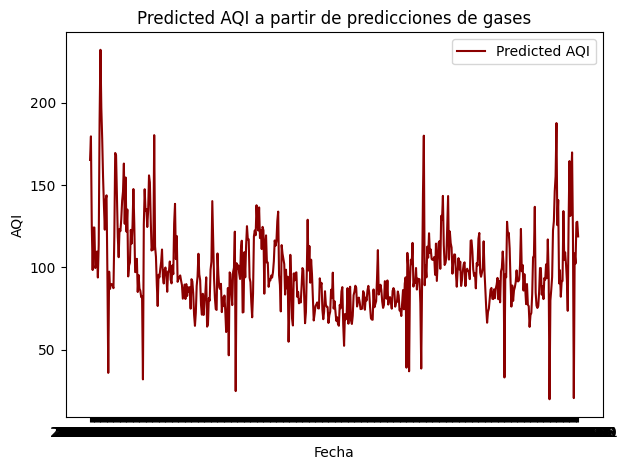

In [ ]:
# columnas de all_preds_real: ["Carbon monoxide", "Nitrogen dioxide (NO2)", "Ozone", "PM2.5 - Local Conditions"]
# para AQI necesitamos: 'PM2.5', 'PM10', 'CO', 'SO2', 'NO2', 'O3_8h', 'O3_1h'

# Como solo tienes estos 4 gases, puedes mapear así:
COLUMN_MAP = {
    "co_avg": "CO",
    "no2_avg": "NO2",
    "o3_avg": "O3_8h",         # si no tienes O3 1h, lo ignoramos
    "pm25_avg": "PM2.5"
}

aqi_results = []

for row in all_preds_real:
    concs = {}
    for i, col in enumerate(["co_avg", "no2_avg", "o3_avg", "pm25_avg"]):
        concs[COLUMN_MAP[col]] = row[i]

    # Calcular AQI usando tu función
    aqi_info = compute_aqi_from_concs(concs)
    aqi_results.append(aqi_info)

# Extraer AQI total y contaminante dominante
aqi_pred = pd.DataFrame([
    {
        "AQI": r['AQI'],
        "Dominant": r['dominant'],
        **r['subindices']  # opcional: agregar subíndices de cada contaminante
    }
    for r in aqi_results
])

# Agregar fechas si quieres
aqi_pred["Date"] = fechas_prueba.reset_index(drop=True)
plt.plot(aqi_pred["Date"], aqi_pred["AQI"], color="darkred", label="Predicted AQI")
plt.title("Predicted AQI a partir de predicciones de gases")
plt.xlabel("Fecha")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()


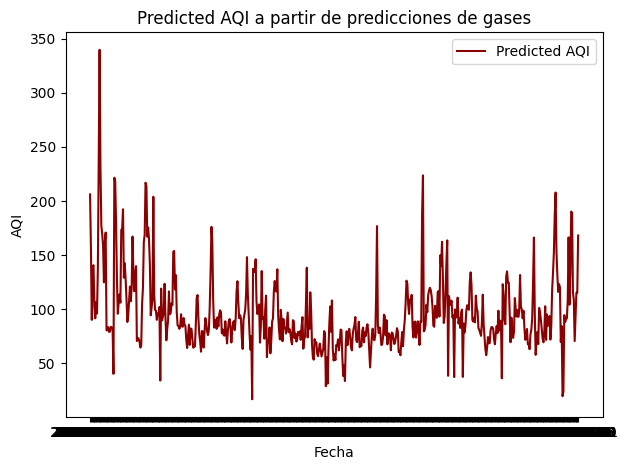

In [ ]:
# columnas de all_preds_real: ["Carbon monoxide", "Nitrogen dioxide (NO2)", "Ozone", "PM2.5 - Local Conditions"]
# para AQI necesitamos: 'PM2.5', 'PM10', 'CO', 'SO2', 'NO2', 'O3_8h', 'O3_1h'

# Como solo tienes estos 4 gases, puedes mapear así:
COLUMN_MAP = {
    "co_avg": "CO",
    "no2_avg": "NO2",
    "o3_avg": "O3_8h",         # si no tienes O3 1h, lo ignoramos
    "pm25_avg": "PM2.5"
}

aqi_results = []

for row in all_labels_real:
    concs = {}
    for i, col in enumerate(["co_avg", "no2_avg", "o3_avg", "pm25_avg"]):
        concs[COLUMN_MAP[col]] = row[i]

    # Calcular AQI usando tu función
    aqi_info = compute_aqi_from_concs(concs)
    aqi_results.append(aqi_info)

# Extraer AQI total y contaminante dominante
aqi_real = pd.DataFrame([
    {
        "AQI": r['AQI'],
        "Dominant": r['dominant'],
        **r['subindices']  # opcional: agregar subíndices de cada contaminante
    }
    for r in aqi_results
])

# Agregar fechas si quieres
aqi_real["Date"] = fechas_prueba.reset_index(drop=True)
plt.plot(aqi_real["Date"], aqi_real["AQI"], color="darkred", label="Predicted AQI")
plt.title("Predicted AQI a partir de predicciones de gases")
plt.xlabel("Fecha")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()


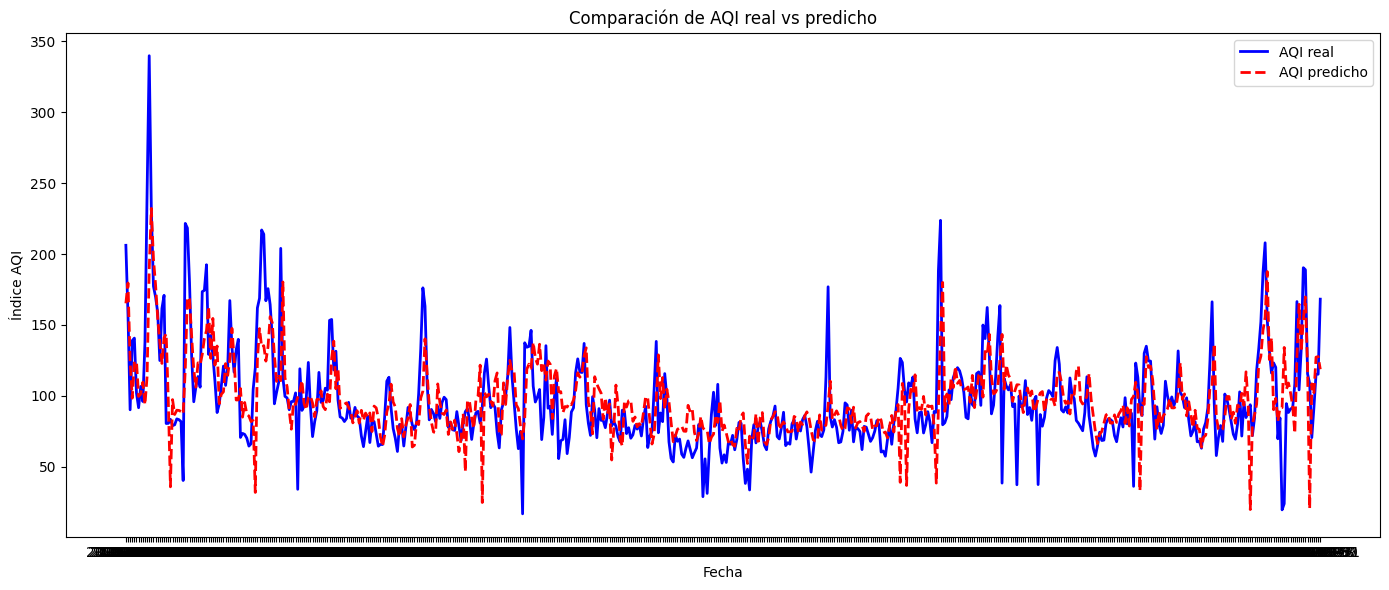

In [ ]:
plt.figure(figsize=(14,6))

# AQI total
plt.plot(aqi_real["Date"], aqi_real["AQI"], color="blue", linewidth=2, label="AQI real")
plt.plot(aqi_pred["Date"], aqi_pred["AQI"], color="red", linewidth=2, linestyle="--", label="AQI predicho")

plt.title("Comparación de AQI real vs predicho")
plt.xlabel("Fecha")
plt.ylabel("Índice AQI")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:


# Colores para cada contaminante
colors_sub = {
    "PM2.5": "#d62728",   # rojo
    "CO": "#2ca02c",      # verde
    "NO2": "#1f77b4",     # azul
    "O3": "#ff7f0e"       # naranja
}

# Crear figura
plt.figure(figsize=(14,6))
plt.plot(aqi_pred["Date"], aqi_pred["AQI"], color="purple", linewidth=2, label="AQI total")  # AQI total en negro

# Graficar cada subíndice si existe
for pollutant in ["PM2.5", "CO", "NO2", "O3"]:
    if pollutant in aqi_pred.columns:
        plt.plot(aqi_pred["Date"], aqi_pred[pollutant], label=f"{pollutant} subíndice", color=colors_sub[pollutant], linewidth=1.5, linestyle="--")

plt.title("AQI total y subíndices de contaminantes")
plt.xlabel("Fecha")
plt.ylabel("Índice AQI")

plt.legend()
plt.tight_layout()
plt.show()